In [1]:
import numpy as np
from numba import jit
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.stats import norm

## Part 1: Basic Option Valuation

In [2]:
def Black_Scholes_Call(S, K, r, vol, tau):
    """ 
    Black Scholes Model for European Call
    """

    d1 = (np.log(S / K) + (r + ((vol**2)/2.)*tau)) / (vol*np.sqrt(tau))
    d2 = d1 - vol*np.sqrt(tau)

    V = S * norm.cdf(d1) - np.exp(-r*tau) * K * norm.cdf(d2)
    
    return V


def Black_Scholes_Put(S, K, r, vol, tau):
    """ 
    Black Scholes Model for European Put
    """
    d1 = (np.log(S / K) + (r + ((vol**2)/2.)*tau)) / (vol*np.sqrt(tau))
    d2 = d1 - vol*np.sqrt(tau)
                          
    V = -S * norm.cdf(-d1) + np.exp(-r * tau) * K * norm.cdf(-d2)
    
    return V

In [3]:
@jit(nopython=True, fastmath = True, parallel=True)
def European_Put(T, K, r, S, sigma, trials):
    '''
    This function calculates the value of an European Put option
    Arguments: maturity, strike price, interest rate, stock price, volaility, number of trials
    Returns: Array of size trial with values of european puts
    '''
    
    S_adjust = S * np.exp(r - (0.5 * sigma**2)*T)
    payoff_array = np.zeros(trials)
    
    for i in range(trials):
        S_cur = S_adjust * np.exp(sigma*np.sqrt(T)*np.random.normal())
        
        if K-S_cur > 0:
            payoff_array[i] = (K-S_cur)*np.exp(-r*T)
        else:
            payoff_array[i] = 0

    return payoff_array

In [5]:
T = 1; K = 99; r = 0.06; S = 100; sigma = 0.2; trials = 100_000_000
max(European_Put(T, K, r, S, sigma, trials))

61.793277664013125

In [4]:
'''
Experiment 1
Price European put option with (T = 1 year, K = 99, r = 6%, S = 100 and σ = 20%).
'''
T = 1; K = 99; r = 0.06; S = 100; sigma = 0.2; trials = 100_000_000
exp_01_data = European_Put(T, K, r, S, sigma, trials)
print(f"The European put is priced at {np.mean(exp_01_data):.4f} +/- {np.std(exp_01_data, ddof=1) / np.sqrt(np.size(exp_01_data)):.4f}")

The European put is priced at 4.7792 +/- 0.0008


In [5]:
"""
For validation, calculate Black-Scholes Put option value with similar parameters 
"""
t = 0
tau = T - t
BS_put = Black_Scholes_Put(S, K, r, sigma, tau)
print("Black Scholes Put Value: ", BS_put)

Black Scholes Put Value:  4.778969051891707


In [6]:
'''
Experiment 2
Carry out convergence studies by increasing the number of trials.
'''
results = Parallel(n_jobs = 8)(delayed(European_Put)(T,K,r,S,sigma,10**i) for i in range(1,8))

In [7]:
y = []; err = []; x = []
# Question asks standard error else multiple by respective Z-score

for i in range(len(results)):
    x.append(len(results[i]))
    y.append(np.mean(results[i]))
    err.append((np.std(results[i])/np.sqrt(x[i])))

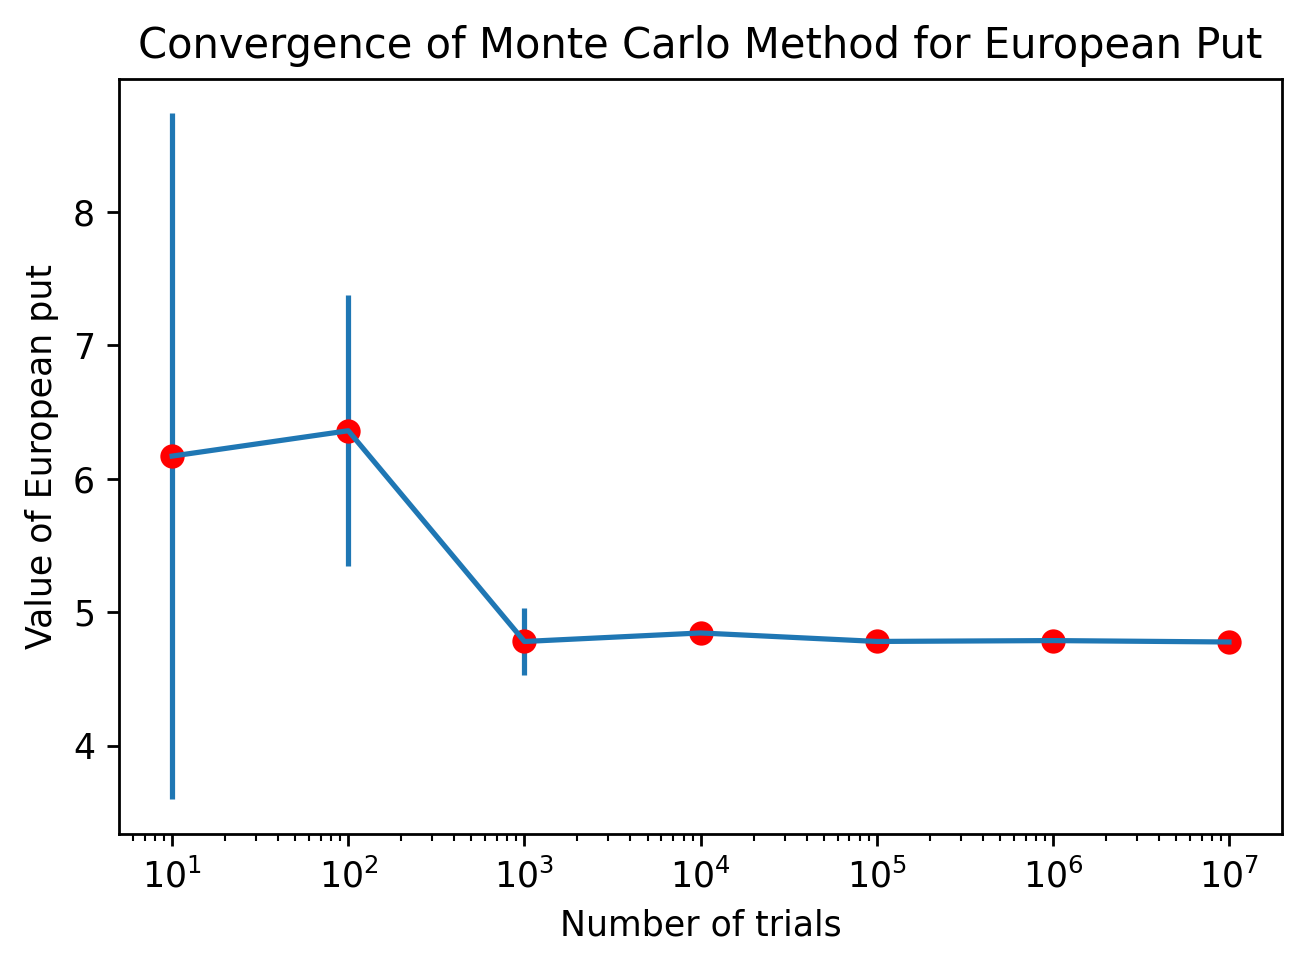

In [8]:
plt.figure(dpi = 250)
plt.errorbar(x, y, err)
plt.plot(x, y, 'ro')
plt.xscale('log')
plt.xlabel("Number of trials")
plt.ylabel("Value of European put")
plt.title("Convergence of Monte Carlo Method for European Put")
plt.show()

# Add anlytical solution line?

In [9]:
'''
Experiment 3
Numerical tests for varying values for the strike and volatility parameter
'''
sigmas = np.linspace(0.1, 2.0, 20)
strikes = np.linspace(1, 200, 20)

In [10]:
results_sigmas = Parallel(n_jobs = 8)(delayed(European_Put)(T,K,r,S,i, 1_000_000) for i in sigmas)
results_strikes = Parallel(n_jobs = 8)(delayed(European_Put)(T,i,r,S,sigma,1_000_000) for i in strikes)

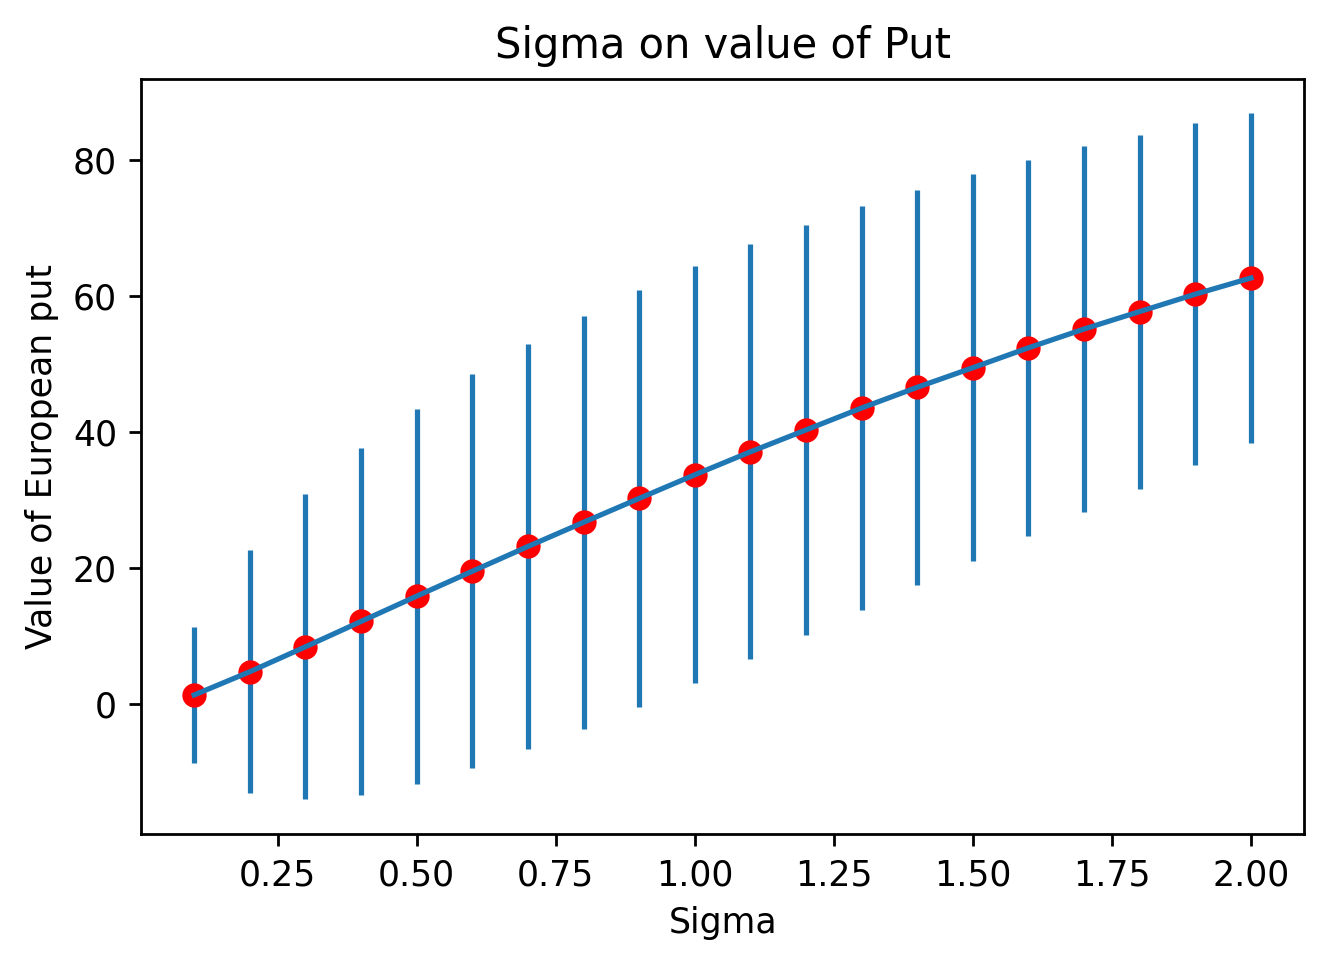

In [11]:
y = []; err = []; x = sigmas
# Question asks standard error else multiple by respective Z-score

for i in range(len(results_sigmas)):
    y.append(np.mean(results_sigmas[i]))
    err.append((np.std(results_sigmas[i])/np.sqrt(x[i])))

plt.figure(dpi = 250)
plt.errorbar(x, y, err)
plt.plot(x, y, 'ro')
plt.xlabel("Sigma")
plt.ylabel("Value of European put")
plt.title("Sigma on value of Put")
plt.show()

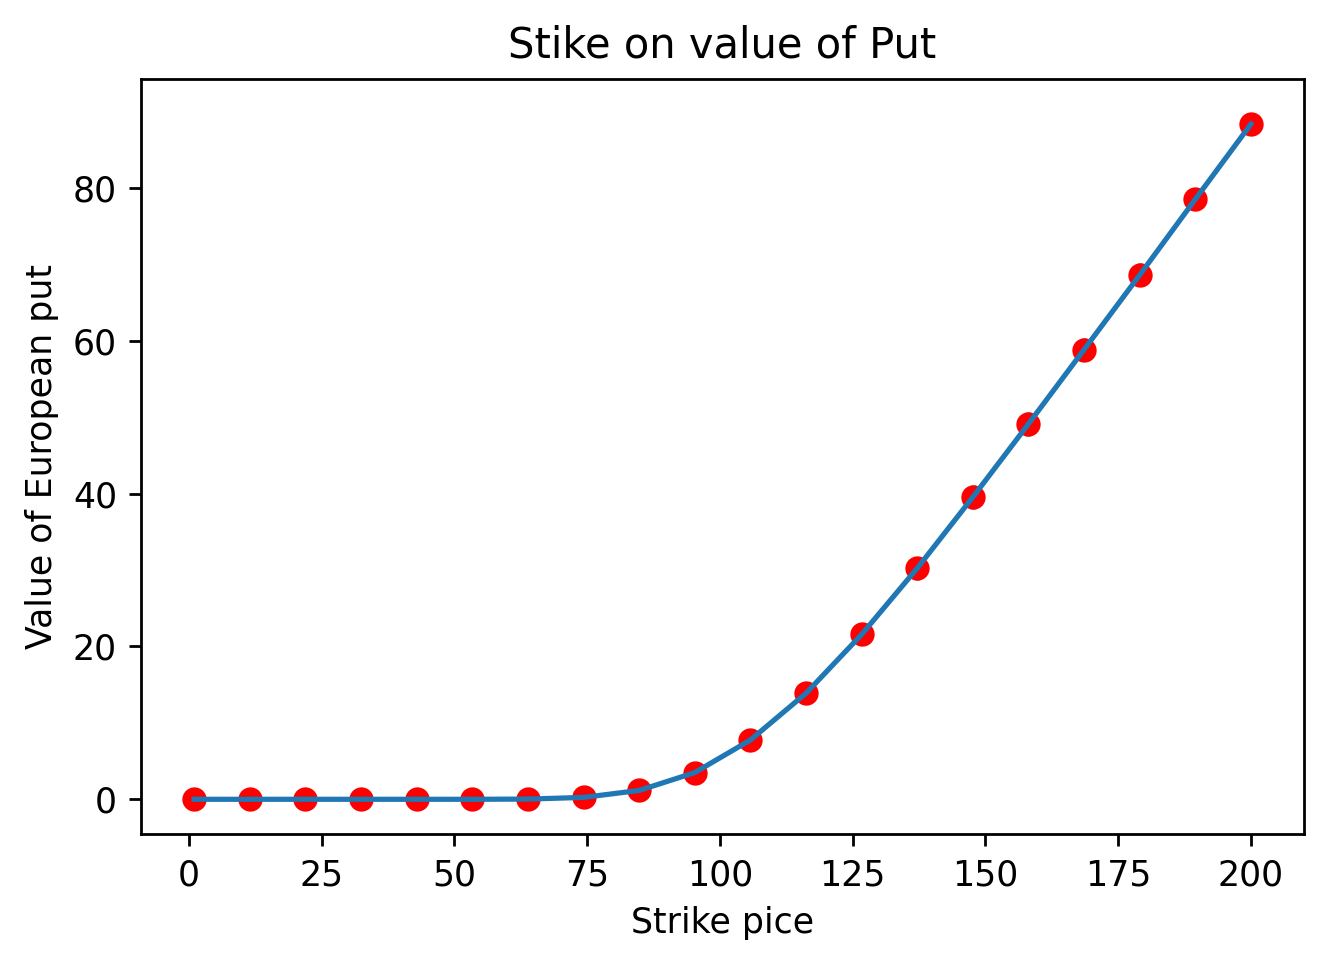

In [12]:
y = []; err = []; x = strikes
# Question asks standard error else multiple by respective Z-score

for i in range(len(results_strikes)):
    y.append(np.mean(results_strikes[i]))
    err.append((np.std(results_strikes[i])/np.sqrt(x[i])))

plt.figure(dpi = 250)
plt.errorbar(x, y, err)
plt.plot(x, y, 'ro')
plt.xlabel("Strike pice")
plt.ylabel("Value of European put")
plt.title("Stike on value of Put")
plt.show()

## Part 2: Estimation of Sensitivities in MC